In [5]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes in Hugging Face dataset."""
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError(f'Missing samples with label value(s) {missing_classes}.')
    if num_classes <= 1:
        raise ValueError(f'Invalid number of labels: {num_classes}.')
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample in a Hugging Face dataset."""
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(dataset, text_column='text', ngram_range=(1, 2), num_ngrams=50):
    """Plots the frequency distribution of n-grams for a Hugging Face dataset."""
    # Extract text samples
    sample_texts = dataset[text_column]

    # Create vectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, dtype='int32', strip_accents='unicode', decode_error='replace', analyzer='word')

    # Fit vectorizer and transform dataset text
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # Extract n-grams and counts
    all_ngrams = vectorizer.get_feature_names_out()
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams by frequency
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])

    # Plot top n-grams
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(dataset, text_column='text'):
    """Plots the sample length distribution (number of characters in each text)."""
    sample_texts = dataset[text_column]
    plt.hist([len(s) for s in sample_texts], bins=50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

def plot_sample_word_count_distribution(dataset, text_column='text'):
    """Plots the distribution of the number of words in each text sample."""
    # Extract the texts from the dataset
    sample_texts = dataset[text_column]
    
    # Calculate the number of words in each text
    word_counts = [len(s.split()) for s in sample_texts]
    
    # Plot the distribution of word counts
    plt.hist(word_counts, bins=50)
    plt.xlabel('Number of words in a sample')
    plt.ylabel('Number of samples')
    plt.title('Distribution of word count per sample')
    plt.show()


def plot_class_distribution(dataset, label_column='label'):
    """Plots the class distribution of labels in a Hugging Face dataset."""
    labels = dataset[label_column]
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()


from wordcloud import WordCloud

def plot_wordcloud(dataset, text_column='text'):
    """Plots a WordCloud from the text samples in the dataset."""
    # Combine all text into a single string
    text_data = " ".join(dataset[text_column])
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # No axis for the WordCloud
    plt.title('WordCloud of Text Samples')
    plt.show()






In [11]:
from datasets import load_dataset
from datasets.features import Value

def detect_text_columns(dataset):
    """Detect all valid text columns in a Hugging Face dataset.

    Args:
        dataset (DatasetDict or Dataset): A loaded Hugging Face dataset.

    Returns:
        list: List of detected text column names that contain actual text (not numbers).
    """
    first_split = list(dataset.keys())[0]  # Get first available split (e.g., 'train')
    features = dataset[first_split].features  # Get dataset schema

    # Identify text columns (dtype should be 'string')
    text_columns = [col for col, dtype in features.items() if isinstance(dtype, Value) and dtype.dtype == "string"]

    # Further filter out columns that contain mostly numbers
    def is_mostly_text(column_data):
        """Returns True if the column contains mostly text (not just numbers)."""
        sample_values = column_data[:100]  # Take a small sample
        return any(any(c.isalpha() for c in str(value)) for value in sample_values)

    dataset_split = dataset[first_split]  # Use the first split to check data
    valid_text_columns = [col for col in text_columns if is_mostly_text(dataset_split[col])]

    return valid_text_columns


def plot_eda(dataset_path, dataset_config=None, label_column=None, split="train"):
    """Exploratory Data Analysis (EDA) for a Hugging Face dataset.

    Args:
        dataset_path (str): The name of the Hugging Face dataset.
        dataset_config (str, optional): The configuration of the dataset (e.g., 'sst2' for GLUE). Default is None.
        label_column (str, optional): The column name in the dataset that contains the labels.
        split (str, optional): The dataset split to analyze ('train', 'test', 'validation', or 'all'). Default is 'train'.
    """
    # Load dataset with or without config
    if dataset_config:
        dataset = load_dataset(dataset_path, dataset_config, trust_remote_code=True)
    else:
        dataset = load_dataset(dataset_path, trust_remote_code=True)

    # If split is "all", analyze all available splits
    if split == "all":
        splits_to_analyze = list(dataset.keys())  # Get all available splits
    else:
        # Check if the specified split exists
        if split not in dataset:
            raise ValueError(f"❌ Split '{split}' not found in dataset. Available splits: {list(dataset.keys())}")
        splits_to_analyze = [split]  # Use a list for consistent processing

    print('Dataset Info:\n', dataset)

    # Detect text columns automatically (assuming the schema is consistent across splits)
    text_columns = detect_text_columns(dataset)
    print(f"📌 Detected text columns: {text_columns}")

    # Iterate over the selected splits
    for current_split in splits_to_analyze:
        print(f"\n🔹 Analyzing split: {current_split}")
        selected_dataset = dataset[current_split]

        if label_column:
            # Get number of classes
            labels = selected_dataset[label_column]
            print(f"Number of classes: {get_num_classes(labels)}")

        for text_column in text_columns:
            print(f"\n📊 Analyzing text column: {text_column}")

            # Get number of words per sample
            sample_texts = selected_dataset[text_column]
            print(f"Median number of words per sample: {get_num_words_per_sample(sample_texts)}")

            # Plot frequency distribution of n-grams (for unigram and bigram)
            plot_frequency_distribution_of_ngrams(selected_dataset, text_column=text_column, ngram_range=(1, 2), num_ngrams=50)

            # Plot sample length distribution
            plot_sample_length_distribution(selected_dataset, text_column=text_column)

            # Plot word count distribution
            plot_sample_word_count_distribution(selected_dataset, text_column=text_column)

            # Plot the WordCloud
            plot_wordcloud(selected_dataset, text_column=text_column)

        if label_column:
            # Plot class distribution
            plot_class_distribution(selected_dataset, label_column=label_column)


Dataset Info:
 DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})
📌 Detected text columns: ['dialogue', 'summary']

🔹 Analyzing split: train

📊 Analyzing text column: dialogue
Median number of words per sample: 73.0


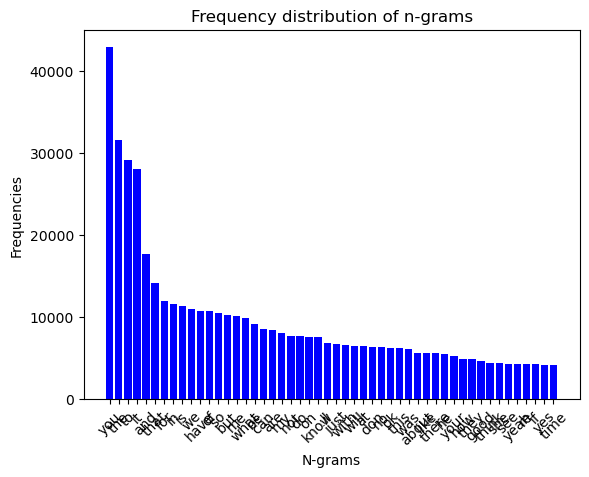

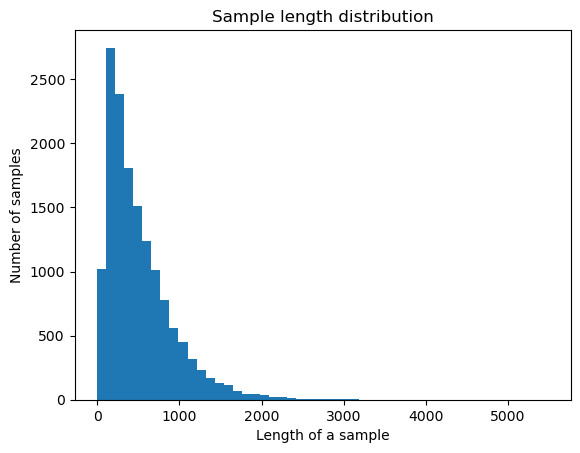

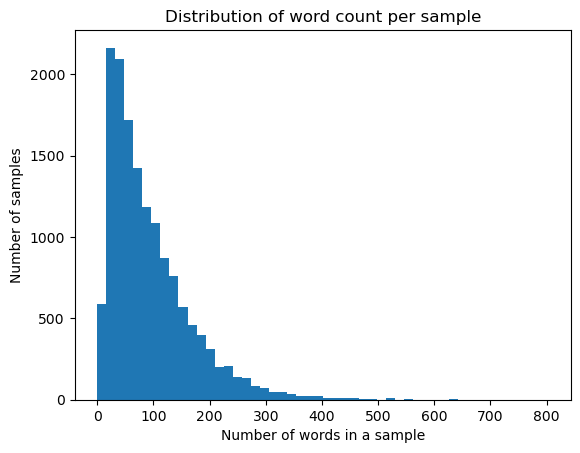

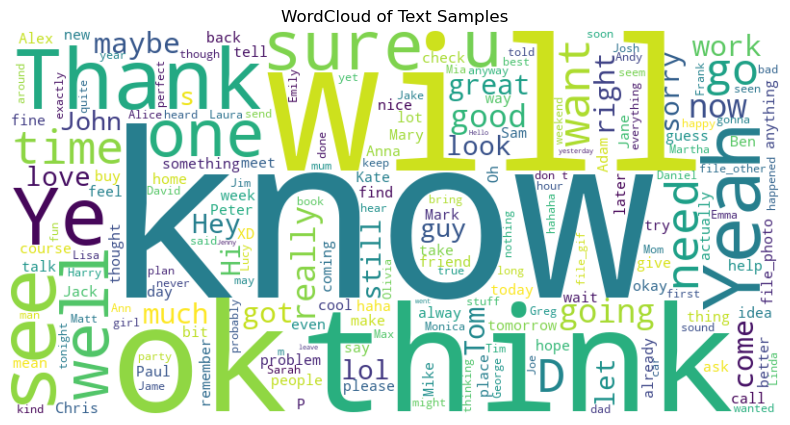


📊 Analyzing text column: summary
Median number of words per sample: 18.0


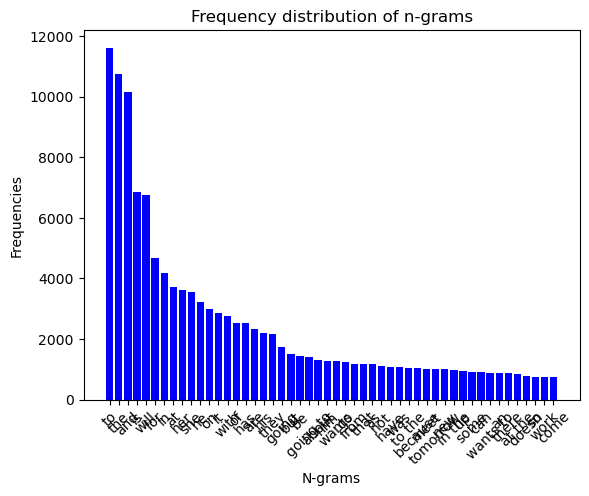

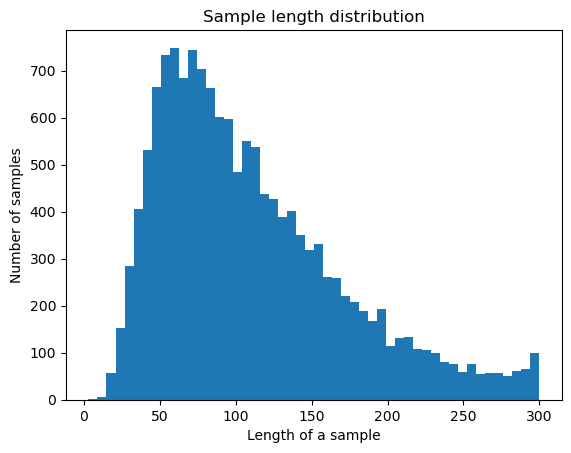

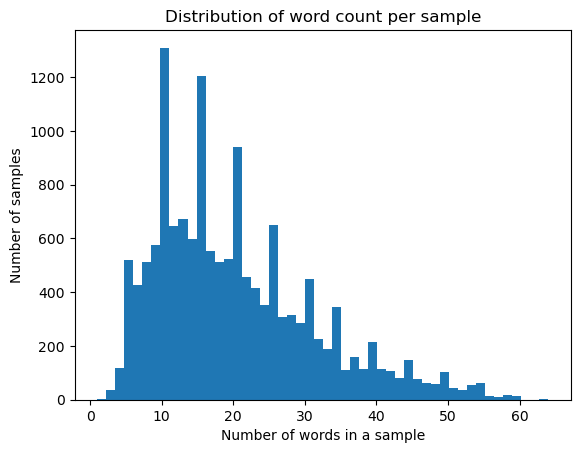

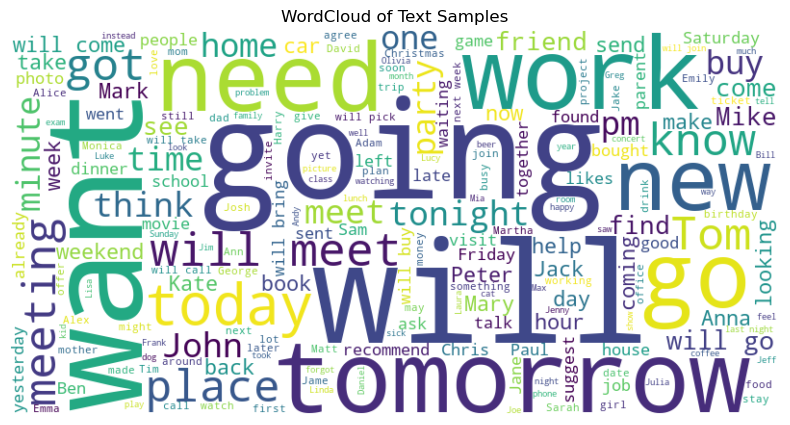

In [12]:
plot_eda('Samsung/samsum', split="train")


Dataset Info:
 DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})
📌 Detected text columns: ['id', 'dialogue', 'summary', 'topic']

🔹 Analyzing split: train

📊 Analyzing text column: id
Median number of words per sample: 1.0


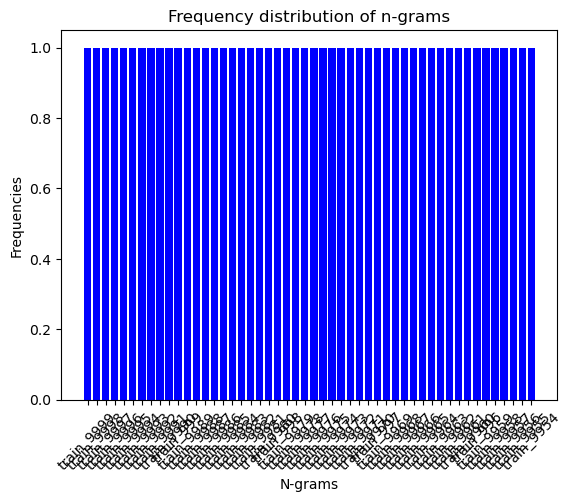

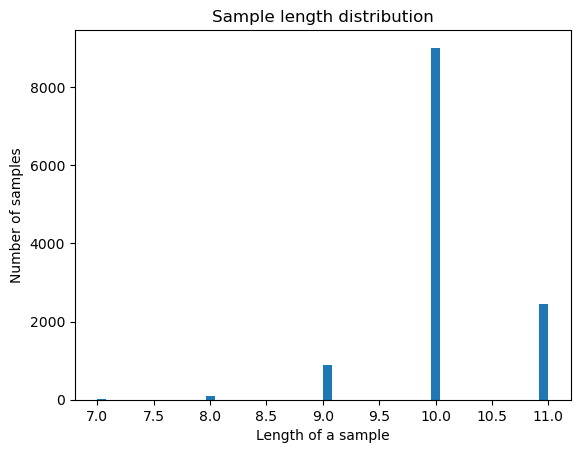

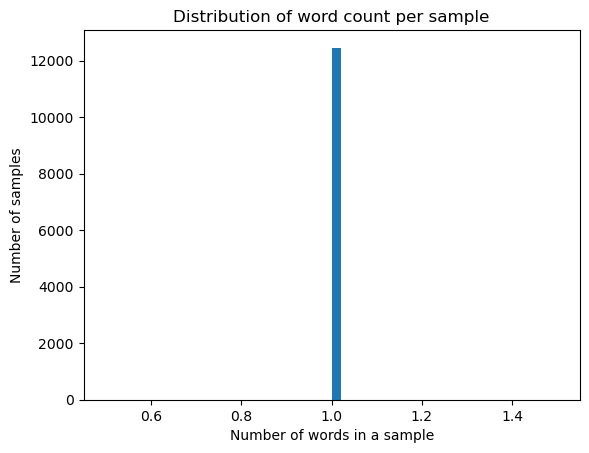

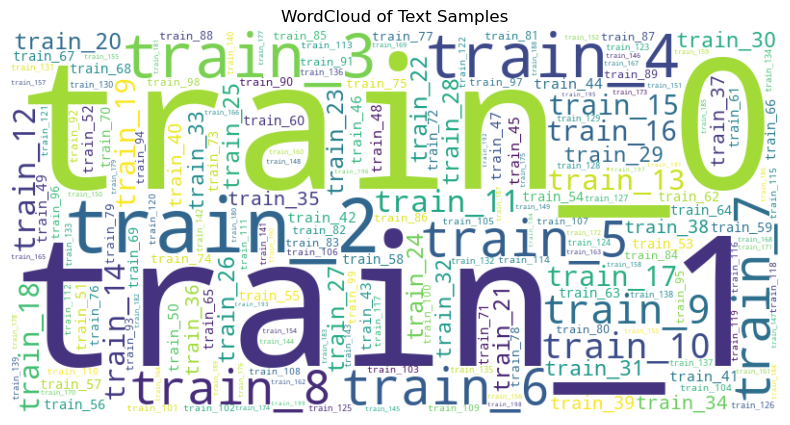


📊 Analyzing text column: dialogue
Median number of words per sample: 116.0


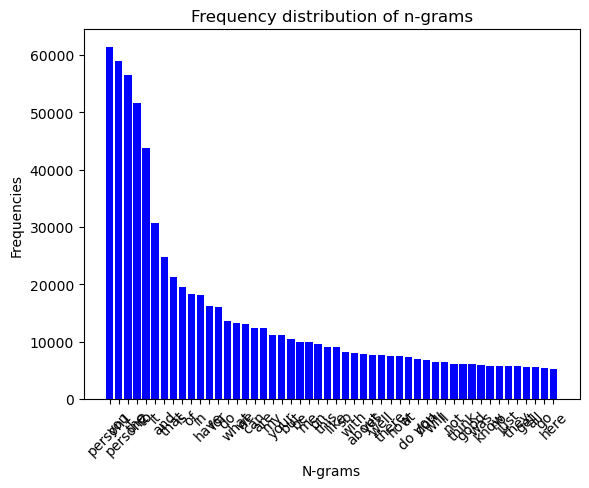

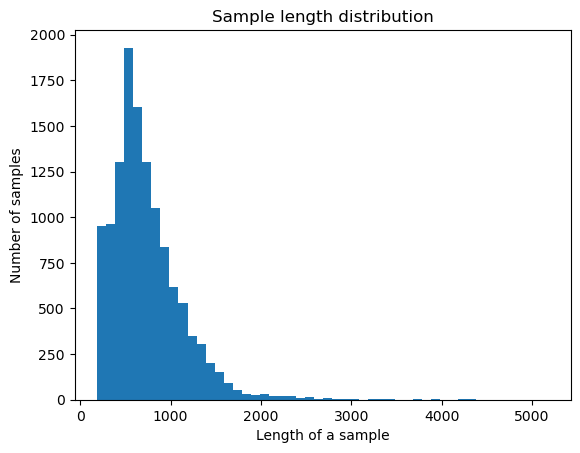

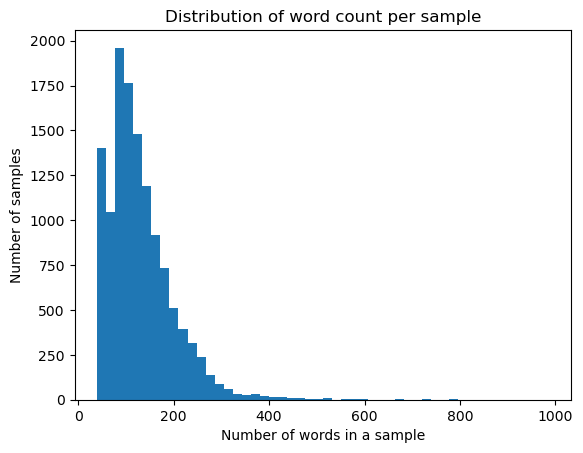

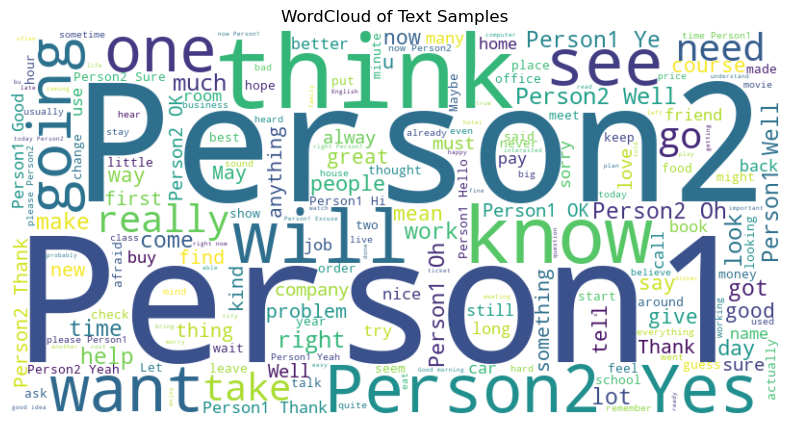


📊 Analyzing text column: summary
Median number of words per sample: 21.0


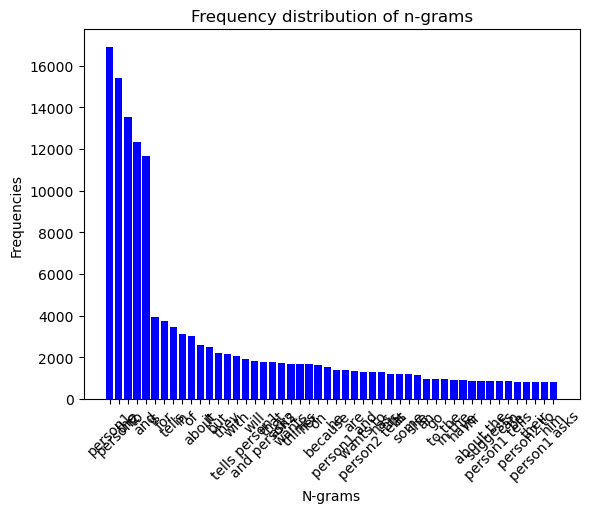

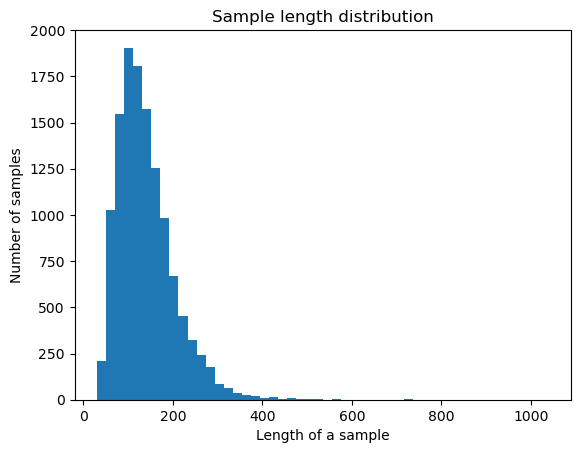

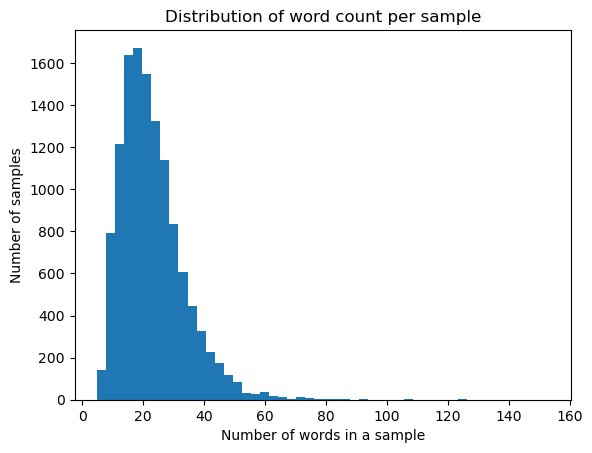

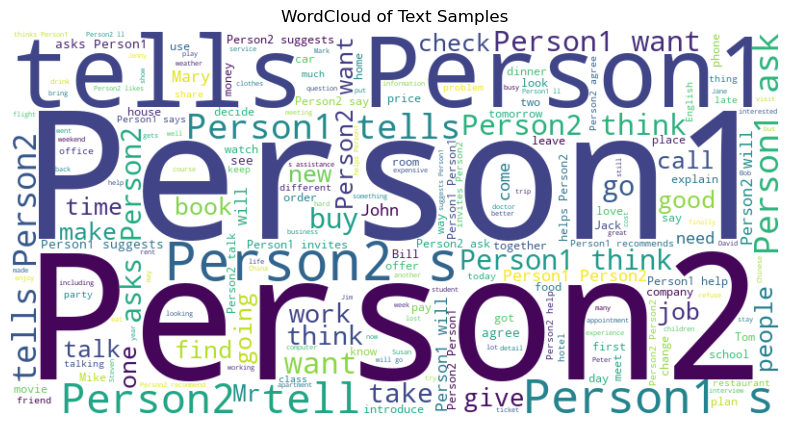


📊 Analyzing text column: topic
Median number of words per sample: 2.0


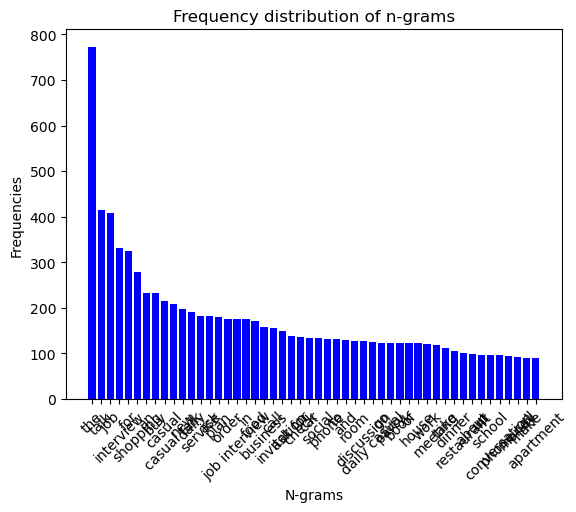

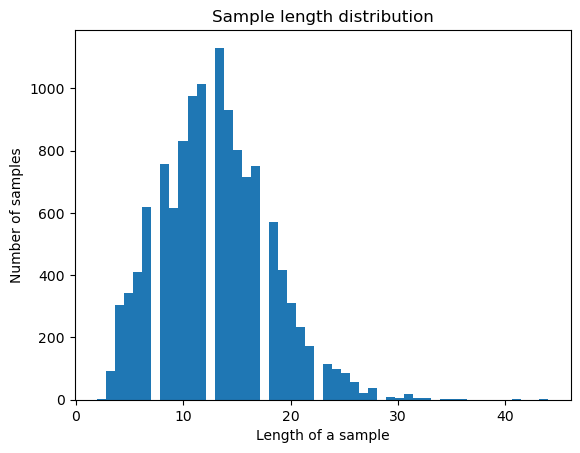

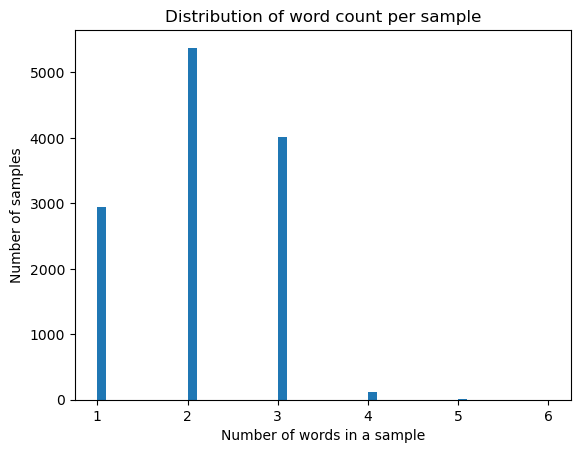

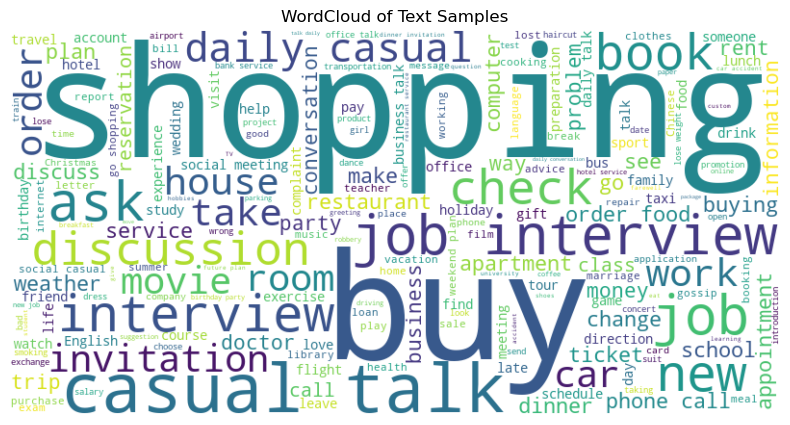

In [13]:
plot_eda('knkarthick/dialogsum', split="train")